## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load Data

In [3]:
# read csv file
data = pd.read_csv('../data/final_20_features.csv')


print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1269, 21)


,test_opiate300_1,test_oxycodone_2,test_methamphetamine_2,test_opiate300_2,test_methamphetamine_3,test_opiate300_3,test_oxycodone_4,test_cocaine_4,test_methamphetamine_4,test_opiate300_4,...,survey_cannabis_4,survey_opiates_4,medication,cows_predose,cows_postdose,rbs_n_sexual_activity,rbs_n_heroin_injection,rbs_heroin_daily_injection,rbs_heroin_non_iv_use,dropout
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,11,6,0.0,30.0,3.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,5.0,0.0,8,1,0.0,30.0,3.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,9.0,1.0,8,5,1.0,30.0,4.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,2.0,6.0,0.0,11,9,1.0,30.0,3.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,11,6,1.0,0.0,0.0,4.0,1.0


In [4]:
X, y = data.drop(columns=['dropout']), data['dropout']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1015, 20)
Shape of X_test: (254, 20)


In [5]:
X_train.iloc[10, :]

test_opiate300_1               1.0
test_oxycodone_2               0.0
test_methamphetamine_2         0.0
test_opiate300_2               1.0
test_methamphetamine_3         0.0
test_opiate300_3               1.0
test_oxycodone_4               0.0
test_cocaine_4                 1.0
test_methamphetamine_4         0.0
test_opiate300_4               1.0
survey_methamphetamine_0       0.0
survey_cannabis_4              0.0
survey_opiates_4              34.0
medication                     1.0
cows_predose                  11.0
cows_postdose                  7.0
rbs_n_sexual_activity          0.0
rbs_n_heroin_injection        30.0
rbs_heroin_daily_injection     6.0
rbs_heroin_non_iv_use          0.0
Name: 265, dtype: float64

Train C-Index: 0.8499574939360616
Test C-Index: 0.7712064676616915


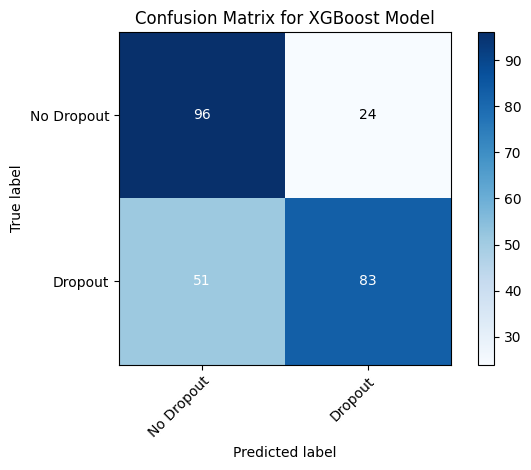

In [6]:
# fit the data to xgb classifier
xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, random_state=42)

# fit the model
xgb.fit(X_train, y_train)

# get the probability scores
y_train_probs = xgb.predict_proba(X_train)[:, 1]
y_test_probs = xgb.predict_proba(X_test)[:, 1]

# convert the probabilities to binary
y_train_preds = (y_train_probs > 0.5).astype(int)
y_test_preds = (y_test_probs > 0.5).astype(int)

# calculate the c-index
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_probs)}")
print(f"Test C-Index: {helper.cindex(y_test.values, y_test_probs)}")

# plot the confusion matrix
helper.plot_confusion_matrix(y_test, y_test_preds, ['No Dropout', 'Dropout'], title='Confusion Matrix for XGBoost Model');

In [7]:
import shap

# create an explainer object
explainer = shap.Explainer(xgb, X_train)

# calculate shap values for the test set
shap_values = explainer(X_test)

# setup array for dependence plots
shap_values_array = shap_values.values

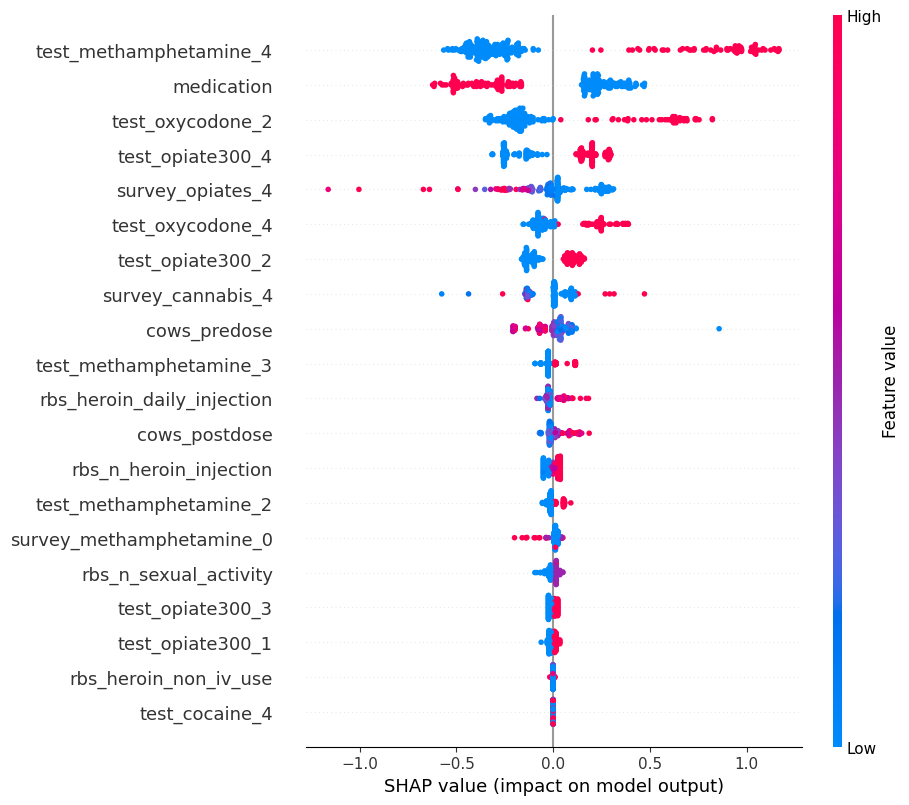

In [10]:
# beeswarm plot
shap.plots.beeswarm(shap_values, max_display=20, show=True)

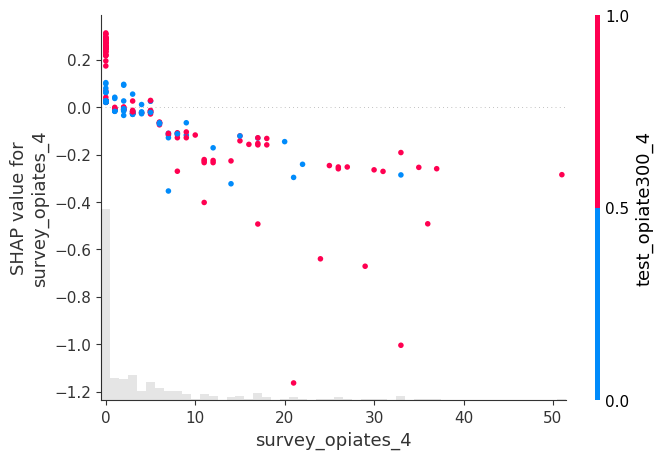

In [11]:
shap.plots.scatter(shap_values[:, 'survey_opiates_4'], color=shap_values[:,'test_opiate300_4'], show=True)

In [12]:
shap.plots.scatter(shap_values[:, 'survey_opiates_0'], color=shap_values[:,'test_opiate300_0'], show=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Look for Interactions - Self Reported Use with Opiate Tests

In [18]:
X_test.columns

Index(['Oxycodone Test - Assessment', 'Cocaine Test - Assessment',
       'Methamphetamine Test - Assessment', 'Opiate 300 Test - Assessment',
       'Oxycodone Test - Week 1', 'Cocaine Test - Week 1',
       'Methamphetamine Test - Week 1', 'Opiate 300 Test - Week 1',
       'Oxycodone Test - Week 2', 'Cocaine Test - Week 2',
       'Methamphetamine Test - Week 2', 'Opiate 300 Test - Week 2',
       'Oxycodone Test - Week 3', 'Cocaine Test - Week 3',
       'Methamphetamine Test - Week 3', 'Opiate 300 Test - Week 3',
       'Oxycodone Test - Week 4', 'Cocaine Test - Week 4',
       'Methamphetamine Test - Week 4', 'Opiate 300 Test - Week 4',
       'Cocaine Survey - Assessment', 'Oxycodone Survey - Assessment',
       'Methamphetamine Survey - Assessment', 'Opiates Survey - Assessment',
       'Cocaine Survey - Week 4', 'Oxycodone Survey - Week 4',
       'Methamphetamine Survey - Week 4', 'Opiates Survey - Week 4',
       'Medication', 'COWS - Pre-Dose Exam', 'COWS - Post-Dose Exam',

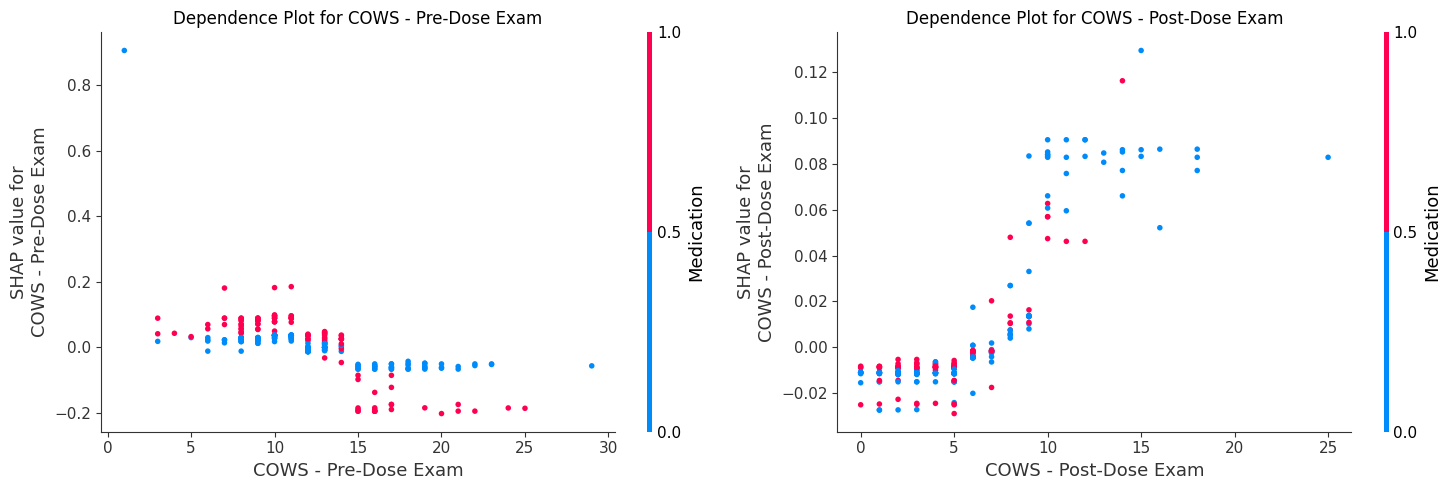

In [19]:
# define features for comparison

# interaction 1
feature1 = 'COWS - Pre-Dose Exam'
feature2 = 'Medication'

# interaction 2
feature3 = 'COWS - Post-Dose Exam'
feature4 = 'Medication'


# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


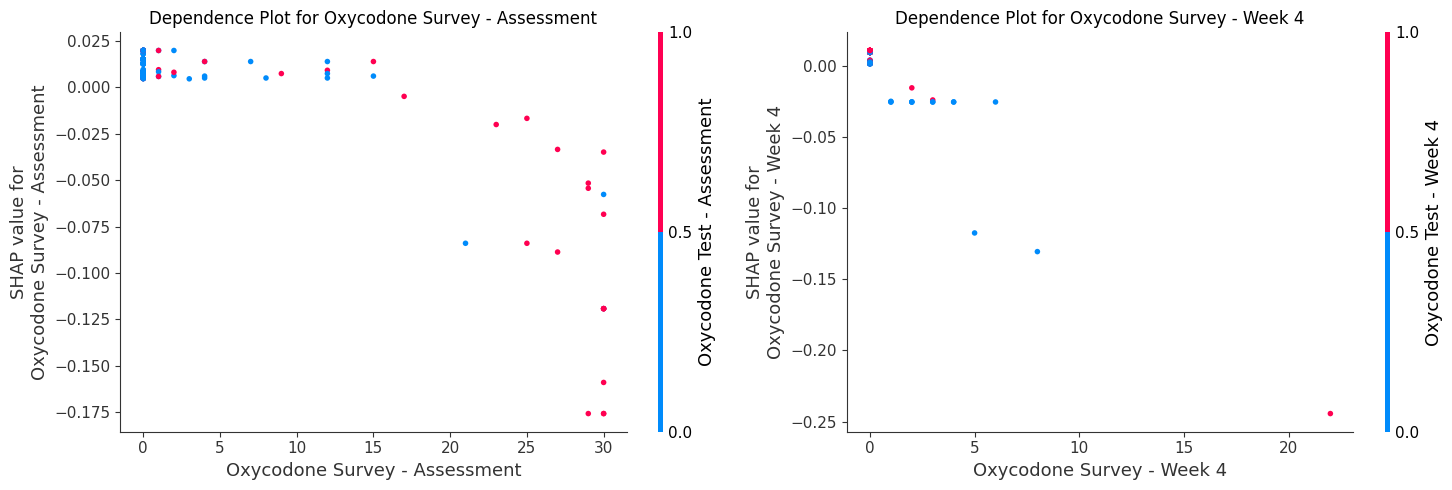

In [20]:
# define features for comparison

# interaction 1
feature1 = 'Oxycodone Survey - Assessment'
feature2 = 'Oxycodone Test - Assessment'

# interaction 2
feature3 = 'Oxycodone Survey - Week 4'
feature4 = 'Oxycodone Test - Week 4'

shap_values_array = shap_values.values

# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


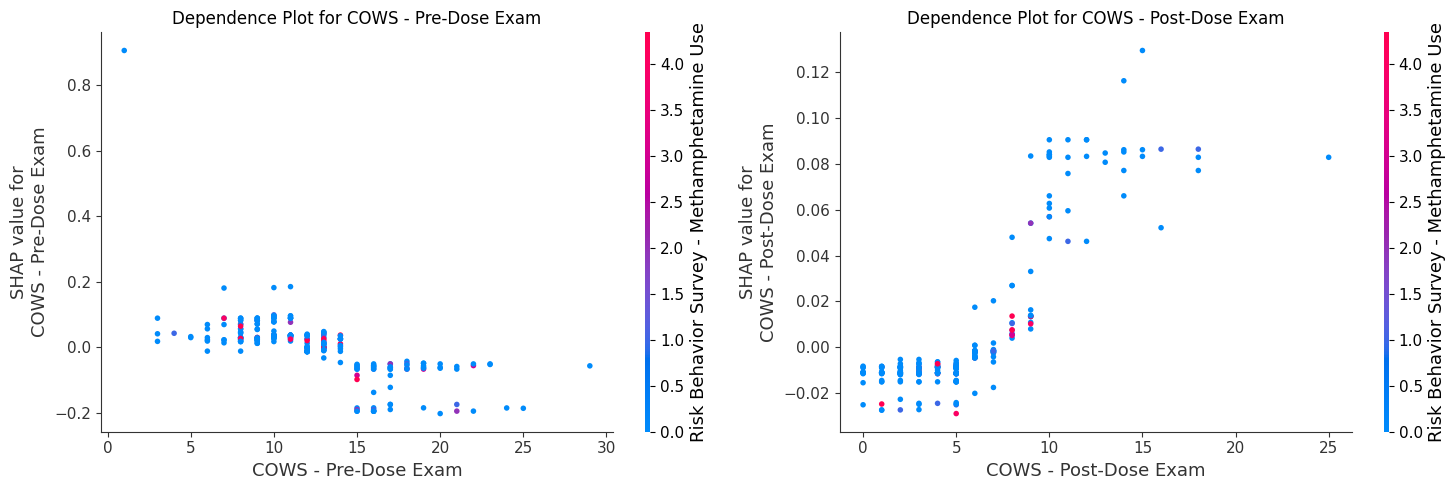

In [21]:
# define features for comparison

# interaction 1
feature1 = 'COWS - Pre-Dose Exam'
feature2 = 'Risk Behavior Survey - Methamphetamine Use'

# interaction 2
feature3 = 'COWS - Post-Dose Exam'
feature4 = 'Risk Behavior Survey - Methamphetamine Use'

shap_values_array = shap_values.values

# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


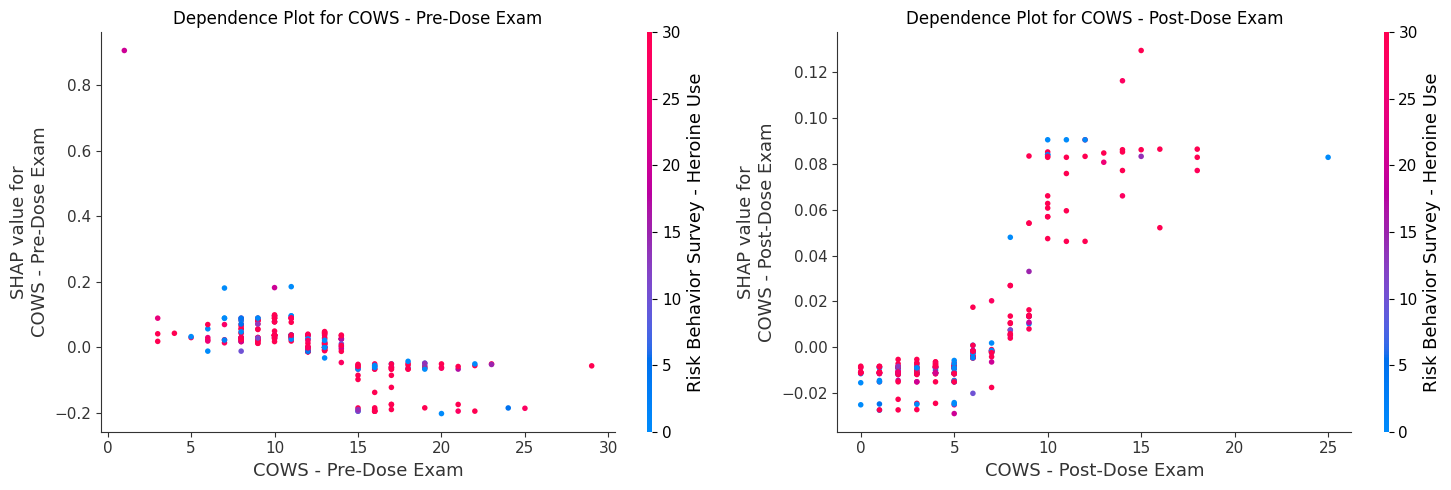

In [22]:
# define features for comparison

# interaction 1
feature1 = 'COWS - Pre-Dose Exam'
feature2 = 'Risk Behavior Survey - Heroine Use'

# interaction 2
feature3 = 'COWS - Post-Dose Exam'
feature4 = 'Risk Behavior Survey - Heroine Use'

shap_values_array = shap_values.values

# call helper to plot dependence
helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_test)


## Look for Interactions - Self Reported Use with Opiate Tests

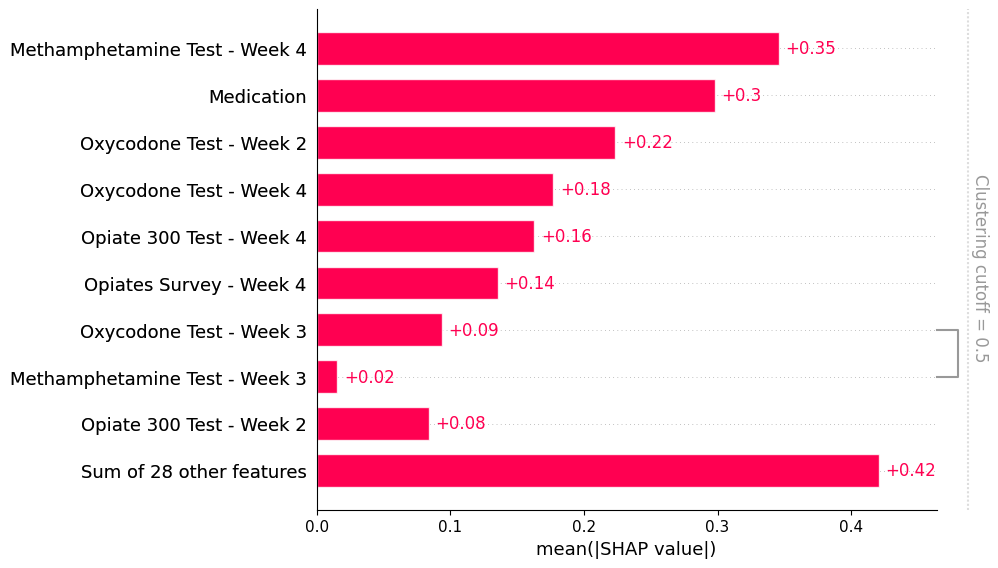

In [23]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering)

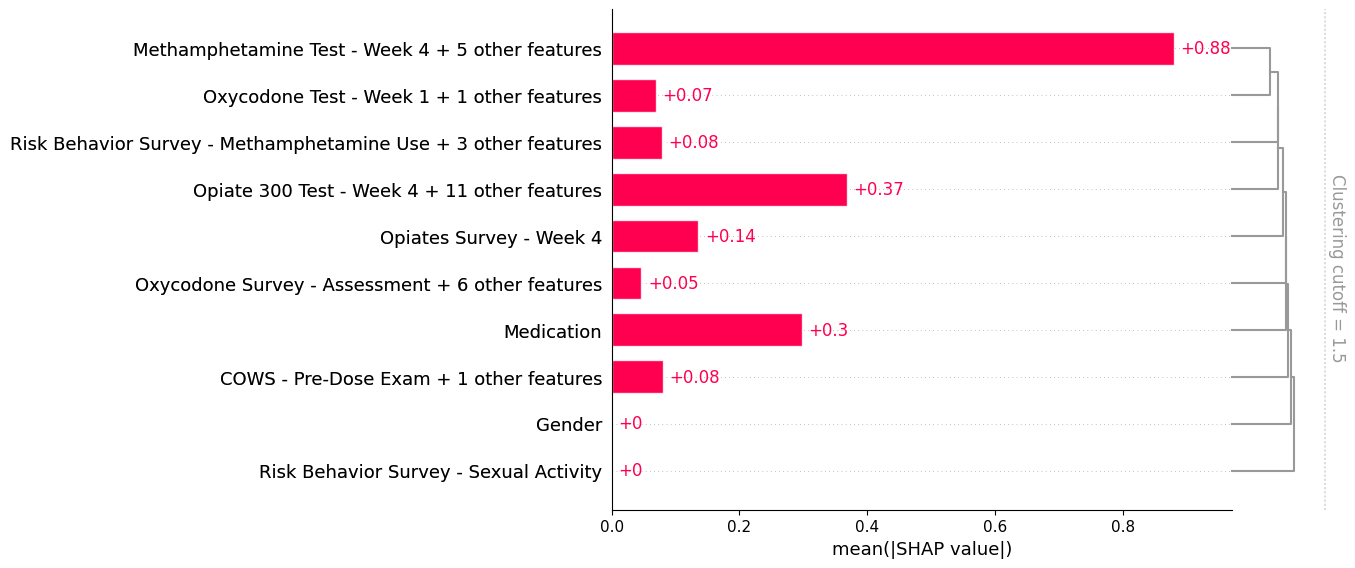

In [24]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.5)

Class index: 1
Data index: 217


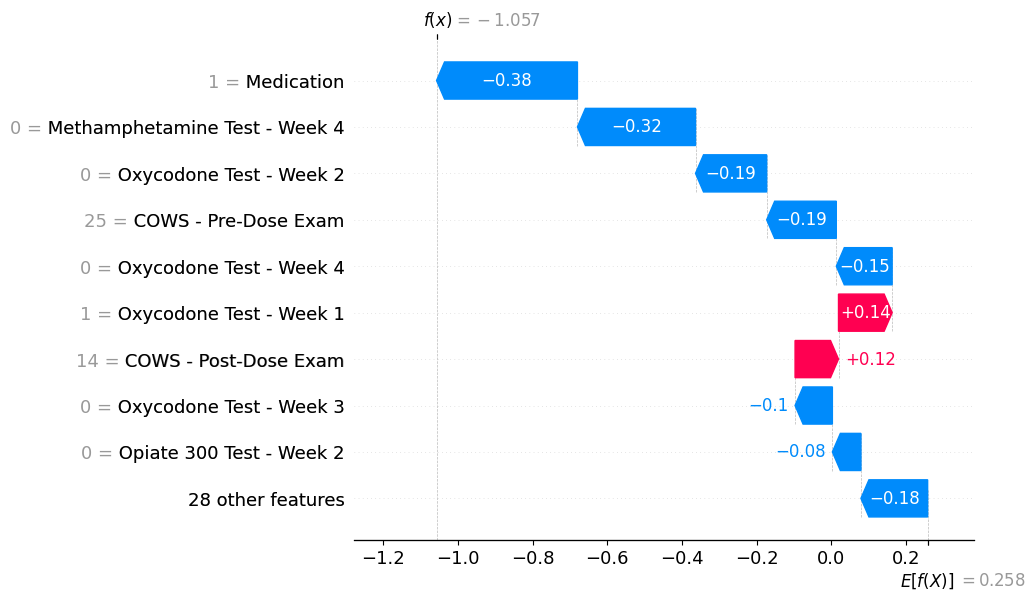

In [25]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[0])

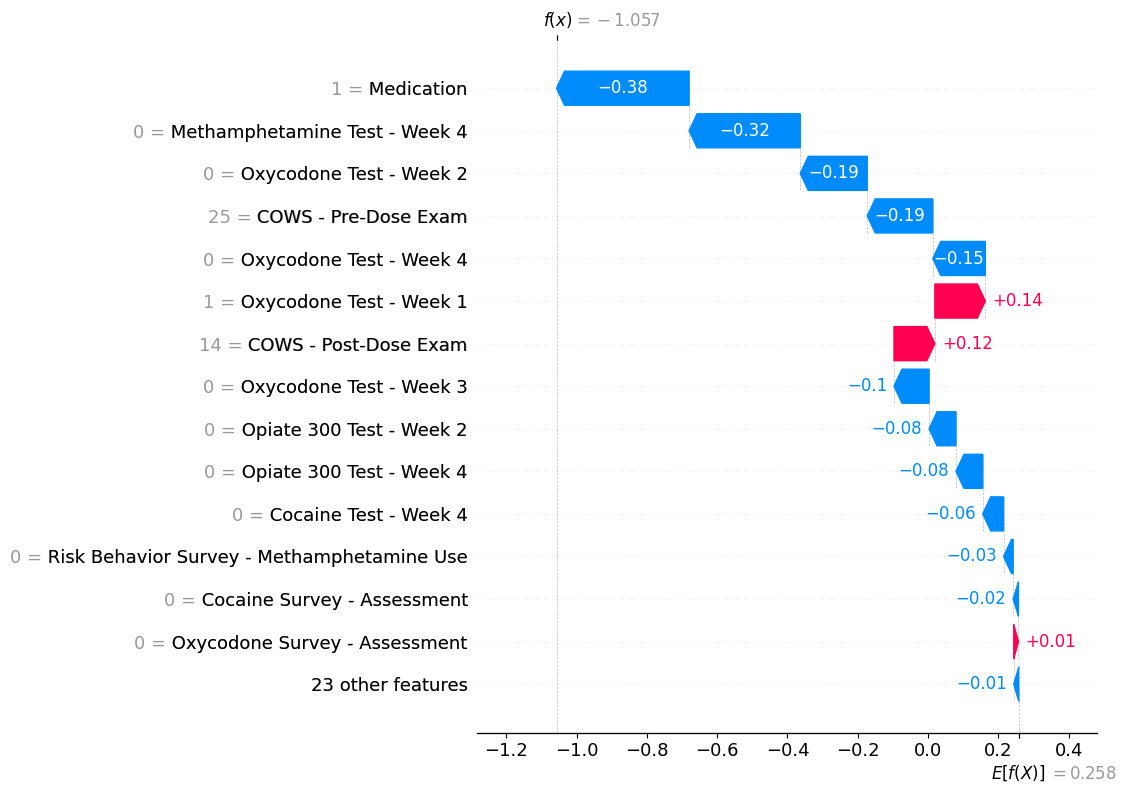

In [26]:
shap.plots.waterfall(shap_values[0], max_display=15)

Class index: 1
Data index: 96


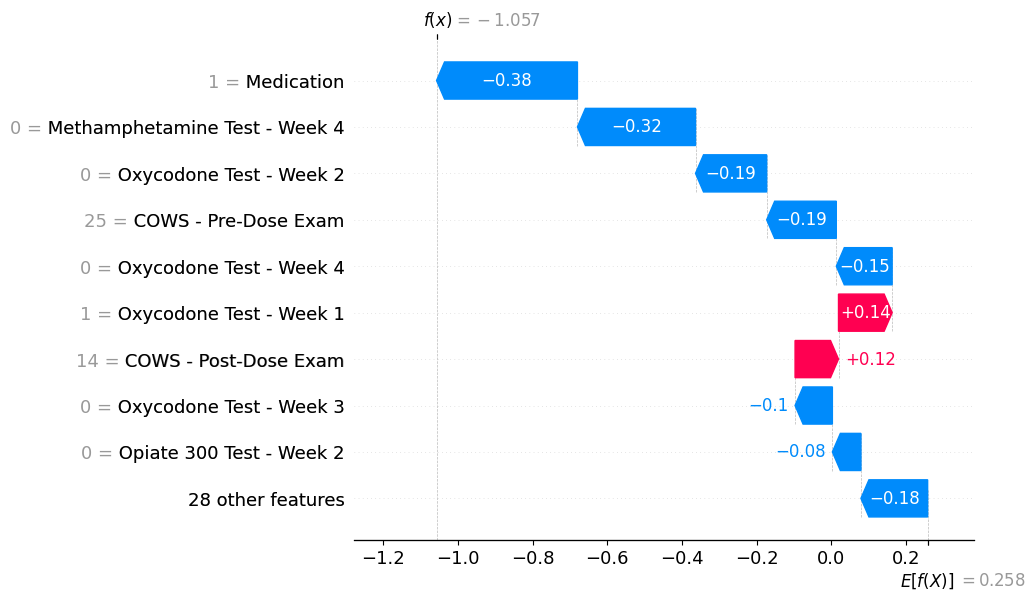

In [27]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[0])

Class index: 1
Data index: 193


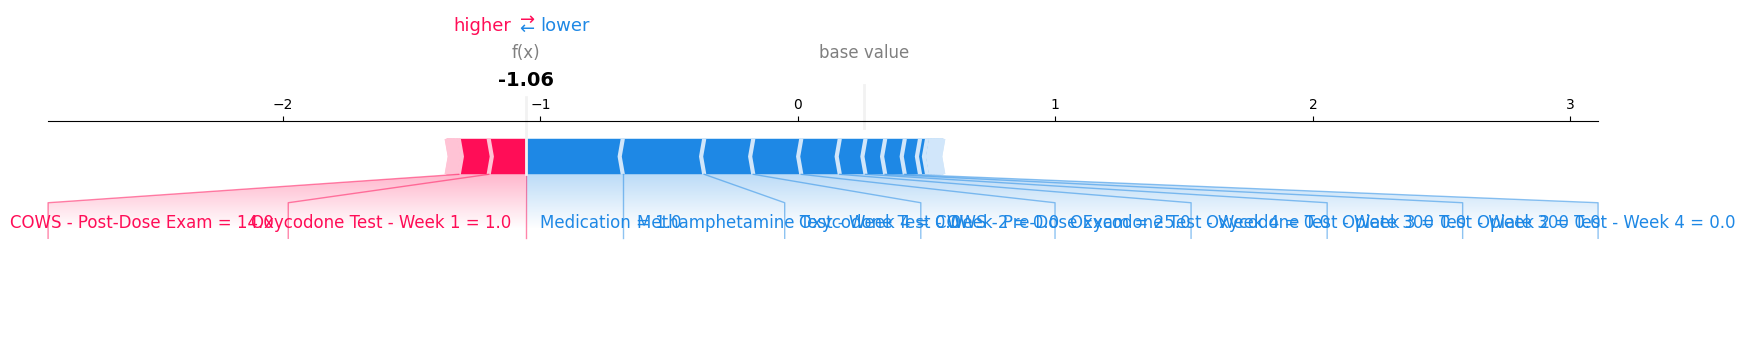

In [31]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[0], matplotlib=True, show=True)